# Robustness Noise 
In order to understand the results better from the testing so far, in particular the plots, we want to analyse how noise influences our computations.
This serves the overall goal of improving our method with noisy data.
Following questions arise:

How can we bound the finite difference method?

How stable is the SVD to noise?

We only consider noise which is normally distributed? Does this influence our result?

What is the relation between the highest and the lowest singular value? Do they grow/shrink in a similar way when confronted with noise?

## SVD Robustness Noise
There is a theorem and a corollary:

Theorem 2.18 (Mirsky). If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\sqrt{\sum_{k=1}^{r}|\sigma_k(A+E) - \sigma_k(A)|} \leq \lVert E \rVert_F$

Corollary:
If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\forall k \ |\sigma_k(A+E) - \sigma_k(A)| \leq \lVert E \rVert$

1. What is the spectral and Frobenius norm of random noise matrices?

In [64]:
import numpy as np
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise
import pysindy as ps
import matplotlib.pyplot as plt

In [2]:
rows,cols = 3,3 #let rows be more than columns
min_value,max_value = -10,10
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
matrix[:, 1] = alpha*matrix[:,2]
print(matrix)

[[ 8.73485461  2.4702799   9.2601214 ]
 [-6.57340951  0.95613093  3.58416407]
 [ 0.36707231 -0.25729179 -0.96448713]]


In [3]:
print(matrix_rank(matrix),svd(matrix, compute_uv=False))
print(np.linalg.norm(matrix))
print(np.linalg.norm(matrix,ord=2))

2 [1.31319644e+01 7.33502793e+00 3.80220601e-17]
15.041646309586639
13.131964396811744


Add noise

In [4]:
#np.random.seed(12)
target_noise=1e-3
var = target_noise * np.sqrt(np.mean(np.square(matrix)))
noise = np.random.normal(0, var, size=matrix.shape)
matrix_noise = matrix + noise
print(f"Added Gaussian noise with variance {var}")

Added Gaussian noise with variance 0.005013882103195546


In [5]:
print("Noise Matrix")
#print(noise)
print(f"Matrix rank: {matrix_rank(noise)}, SVD: {svd(noise, compute_uv=False)}")
print(f"Frobenius norm:\t {np.linalg.norm(noise)}")
print(f"Spectral norm:\t {np.linalg.norm(noise,ord=2)}")

Noise Matrix
Matrix rank: 3, SVD: [0.00607131 0.00543863 0.0027208 ]
Frobenius norm:	 0.00859315452343208
Spectral norm:	 0.00607131011375574


Print SVD and matrix rank with additional noise

In [6]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t \t matrix rank \t svd \t \t \t \t \t \t \t Frobenius \t \t \t Spectral")
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix + noise
    print(f" {target_noise}      \t \t {matrix_rank(matrix_noise)} \t \t {svd(matrix_noise, compute_uv=False)}     \t {np.linalg.norm(noise)}      \t {np.linalg.norm(noise,ord=2)}")

Noise level 	 	 matrix rank 	 svd 	 	 	 	 	 	 	 Frobenius 	 	 	 Spectral
 0      	 	 2 	 	 [1.31319644e+01 7.33502793e+00 3.80220601e-17]     	 0.0      	 0.0
 1e-10      	 	 3 	 	 [1.31319644e+01 7.33502793e+00 7.98982941e-11]     	 9.865793899025576e-10      	 9.46075384734493e-10
 1e-09      	 	 3 	 	 [1.31319644e+01 7.33502793e+00 4.46233173e-09]     	 1.3149854557019309e-08      	 1.0924949836495216e-08
 1e-08      	 	 3 	 	 [1.31319644e+01 7.33502784e+00 1.38216700e-08]     	 1.3273580842643304e-07      	 1.2417712305885877e-07
 1e-07      	 	 3 	 	 [1.31319634e+01 7.33502789e+00 1.90232418e-07]     	 1.4480058312437473e-06      	 1.2058976443254134e-06
 1e-06      	 	 3 	 	 [1.31319651e+01 7.33503234e+00 5.36552117e-06]     	 1.791812316990572e-05      	 1.640292369332763e-05
 1e-05      	 	 3 	 	 [1.31318848e+01 7.33505554e+00 2.10208959e-05]     	 0.00013457907104821257      	 0.00011884717883438572
 0.0001      	 	 3 	 	 [1.31323910e+01 7.33479377e+00 1.73450120e-04]     	 0.

Although the Frobenius Norm might not be that high in relation to the highest singular value. In relation to the smallest singular value it can be quite significant. Thus, the changes in the smallest singular value can be more disturbing for our purpose.

## Finite Difference Noise

We can find the coefficients use to calculate the finite differences for different orders in https://en.wikipedia.org/wiki/Finite_difference_coefficient.<br>
Assuming we have equispaced data for x,and we can bound the measurement error by $\epsilon > 0$ i.e. $||u-\tilde{u}||_{\infty}< \epsilon$ and the third derivative of u
is bounded by $M(t, x) > 0$ on each interval $[x − h, x + h]$. Then, we get that
$$|u_x(t, x) − \tilde{u}_x(t, x)| ≤ \frac{\epsilon}{h} + \frac{h^2}{6}M(t,x)$$
is the 2nd order centered finite differences approximation of the derivative of $\tilde{u}$.

TODO: error bound for different orders, centered and left-off-centered/backward differences (even/odd order)?<br>
Question: do the same error bounds count at the boundary values of u??

For even order: centered differenced, for uneven order backward differences:<br>
order = 1: <br>
Approximation: $\frac{u(x)-u(x-h)}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h}{2}||u'||_{\infty}+\frac{2\epsilon}{h}$ 
<br>
order = 2: <br>
Approximation: $\frac{u(x+\frac{h}{2})-u(x-\frac{h}{2})}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^2}{3}||u^3||_{\infty}+\frac{2\epsilon}{h}$ <br>
(Here we use h/2 since for h the calculation did not work out -> makes more sense???)
order = 4: <br>
Approximation: see book or wiki,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^4}{30}||u^5||_{\infty}+\frac{9 \epsilon}{6h}$ <br>

In [419]:
from test_data import create_data_2d
experiment_name = "linear_nonunique_1"
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
dx=x[1]-x[0]

In [420]:
ux_fd = ps.FiniteDifference(order=3,d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux_fd.flatten()
g= np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print(g.shape)
print(f"Matrix rank = {matrix_rank(g)}, svd = {svd(g, compute_uv=False)}")

(40000, 2)
Matrix rank = 2, svd = [9.49481347e+03 3.78401580e-03]


### Check difference between noisy derivative and correct derivative

General formula for central differences: $$ \text{sum over ceofficients} + h^{order}\frac{order}{(order+1)!}$$

In [451]:
#only for even orders
#does not work yet!
def calculate_sum_coefficients_lagrange_poly(order):
    erg=0.0
    orderfac = np.math.factorial(order)**2
    for p in range(1,int(order/2)+1):
        print(p)
        coeff = 2*orderfac*(-1)**(p+1)/( p * np.math.factorial(order-p) * np.math.factorial(order+p) )
        print(coeff)
        erg+=coeff
    return erg
                                                                                        

In [468]:
25/12

2.0833333333333335

In [463]:
(4/5+1/5+4/105+1/280 )*2

2.0833333333333335

In [453]:
calculate_sum_coefficients_lagrange_poly(2)

1
1.3333333333333333


1.3333333333333333

In [478]:
#eps: measurement error+roundof error (Does it make sense to add machine precision?)
#h: dx for equispaced data
#M: bound on nth derivative depending on the order
def error_bound(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order ==1:
        #backward differences order 1
        return 2*eps/h + h/2*M
    elif order==2:
        return 2*(eps/h + h*h/6*M) #is fixed with 2* but why???
    elif order==4:
        return 9.0/6.0*eps/h + h**4/30*M
    elif order==6:
        return 11/6.0*eps/h + h**6/144*M
    elif order==8:
        return 25/12*eps/h + h**8/840*M
    else:
        #TODO: for now order 2
        return 2*eps/h + h*h/3.0*M
            
def infinity_norm(x):
    return np.max(np.abs(x))

In [511]:
target_noise=1e-7
var = target_noise * np.sqrt(np.mean(np.square(u)))
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
ux_noise = ps.FiniteDifference(order=4,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)

In [513]:
infinity_norm(ux-ux_noise)

0.0027138708804015366

In [514]:
eps=infinity_norm(u_noise-u)
M=infinity_norm(uxxx)
h=dx
print(f"eps: {eps}, M: {M}, h: {h}")

eps: 1.564005622345377e-05, M: 148.4131591025766, h: 0.02512562814070352


In [515]:
error_bound(eps,h,M,order=4)

0.0009356829568123003

Error bound smaller than difference for oder =^1? -> wrong formula
three poiint midpoint ?/ numerical mistakes in error bound calcuation?<br>
Why do I get 2* factor for order ="???

Noise level 	  eps 	 	 $max|ux-ux_noise|$ 	 bound
0 	 	  0.0000 	 0.0000 	 	 0.0000
1e-10 	 	  0.0000 	 0.0000 	 	 0.0000
1e-09 	 	  0.0000 	 0.0000 	 	 0.0000
1e-08 	 	  0.0000 	 0.0002 	 	 0.0001
1e-07 	 	  0.0000 	 0.0024 	 	 0.0009
1e-06 	 	  0.0002 	 0.0219 	 	 0.0091
1e-05 	 	  0.0015 	 0.2008 	 	 0.0868
0.0001 	 	  0.0141 	 2.2850 	 	 0.8433
0.001 	 	  0.1536 	 21.7347 	 	 9.1682
0.01 	 	  1.6297 	 229.2445 	 	 97.2948
0.1 	 	  14.3832 	 2391.9740 	 	 858.6754


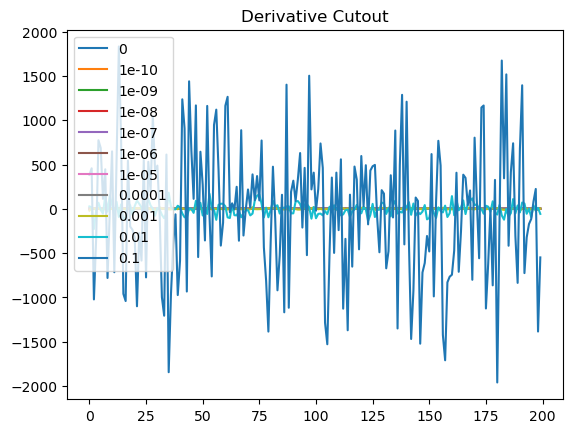

In [509]:
M=infinity_norm(uxxx)
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t  eps \t \t $max|ux-ux_noise|$ \t bound")
plt.title("Derivative Cutout")
order=4
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(u)))
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    plt.plot(ux_noise[0,:],label=str(target_noise))
    eps = infinity_norm(u_noise-u)
    bound = error_bound(eps,dx,M,order)
    diff = infinity_norm(ux-ux_noise)
    print(f"{target_noise} \t \t  {eps:.4f} \t {diff:.4f} \t \t {bound:.4f}")
plt.legend()
plt.show()

In [486]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,2)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        eps = infinity_norm(u_noise-u)
        bound = error_bound(eps,dx,M,order)
        diff = infinity_norm(ux-ux_noise)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
2
	 0	 	  0.000 	 0.0306 	 0.0312
	 1e-10	 	  0.000 	 0.0307 	 0.0312
	 1e-09	 	  0.000 	 0.0306 	 0.0312
	 1e-08	 	  0.000 	 0.0307 	 0.0313
	 1e-07	 	  0.000 	 0.0309 	 0.0325
	 1e-06	 	  0.000 	 0.0339 	 0.0418
	 1e-05	 	  0.001 	 0.1053 	 0.1396
	 0.0001	 	  0.015 	 1.2160 	 1.2527
	 0.001	 	  0.136 	 10.4426 	 10.8639
	 0.01	 	  1.666 	 111.7189 	 132.6521
4
	 0	 	  0.000 	 0.0000 	 0.0000
	 1e-10	 	  0.000 	 0.0000 	 0.0000
	 1e-09	 	  0.000 	 0.0000 	 0.0000
	 1e-08	 	  0.000 	 0.0003 	 0.0001
	 1e-07	 	  0.000 	 0.0024 	 0.0008
	 1e-06	 	  0.000 	 0.0241 	 0.0081
	 1e-05	 	  0.001 	 0.2271 	 0.0826
	 0.0001	 	  0.014 	 2.2633 	 0.8579
	 0.001	 	  0.163 	 24.1641 	 9.7278
	 0.01	 	  1.667 	 195.5470 	 99.5008
6
	 0	 	  0.000 	 0.0000 	 0.0000
	 1e-10	 	  0.000 	 0.0000 	 0.0000
	 1e-09	 	  0.000 	 0.0001 	 0.0000
	 1e-08	 	  0.000 	 0.0005 	 0.0001
	 1e-07	 	  0.000 	 0.0050 	 0.0011
	 1e-06	 	  0.000 	 0.0540 	 0.0105
	 1e-05	

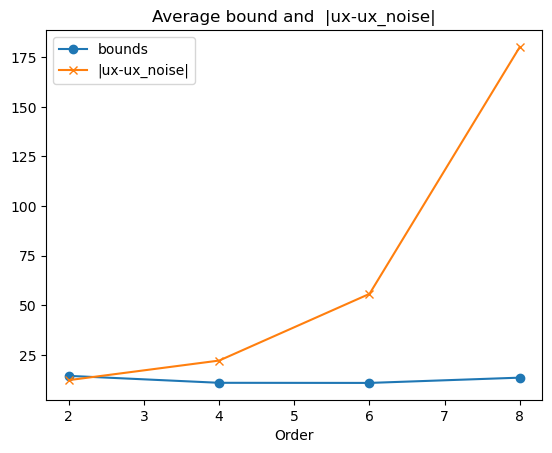

In [487]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()